## Computational Essay Project FYS1120

### Contact info:

#### Synnøve Isabel Wallentin Sandstrøm

E-mail: sisandst@student.matnat.uio.no

#### Jarl-Robin Bjerkgård Evensen

E-mail: jrevense@student.matnat.uio.no

# Introduction: 2D Stormcloud, with lightning and lightning rod

In this notebook, we will model the path of a bolt of lightning when there is a lightning rod present. This simulation will create a grid of points and then solve Poisson's equation on that grid in order to find the electric potential throughout the 2D space. Based on that electric potential, it will predict where the lightning strike begins, then repeat the process to see how it advances.

After we've modelled the lightning strike we will see how a lightning rod setup will handle being struck by lightning, more specifically how it will handle the amount of energy in the strike and then evaluate whether the setups seem safe.

To calculate this we make simplified models of the rods and wires, calculate the resistances for different materials and gauges of wire, calculate for a range of currents in the strikes and finally compare the temperature rise in the system to the melting point of the PVC insulation around the wires.

First, we import the essential tools: numpy, matplotlib, pandas and numba to speed up calculations, and handle data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numba import jit
import pandas as pd

Next, we define a function that will solve Poisson's equation on a rectangular grid, using a method called the "method of relaxation." This method relies on the fact that, as long as there are no charges in a region, the potential in that region will only change gradually. So, given a set of boundary conditions (places where the potential is specified or well defined) we can find the values of electric potential at certain points by averaging the potential of neighboring points. By doing this over and over, we eventually get a stable solution.

In the following function, the boundary conditions are given by the array b. In the points where b is defined (has a value), the boundary conditions are assumed to be this value. Where b is 'nan' (not defined—that is, we have yet to find it) we use the method of relaxation to find the value.

In [2]:
@jit(cache=True)
def solvepoisson(b,nrep):
    # b = boundary conditions
    # nrep = number of iterations

    z = np.copy(b)     # z = electric potential field
    j = np.where(np.isnan(b)) #checks for where the points have no value, assigns them the value 0
    z[j] = 0.0
    
    znew = np.copy(z)
    Lx = np.size(b,0) # determine the x range of the point grid
    Ly = np.size(b,1) # determine the y range of the point grid
    
    for n in range(nrep): 
        for ix in range(Lx):
            for iy in range(Ly):
                ncount = 0.0 
                pot = 0.0
                if (np.isnan(b[ix,iy])): # check for cases in which the value is unspecified in the original grid
                    # Now, add up the potentials of all the the points around it
                    if (ix>0): 
                        ncount = ncount + 1.0
                        pot = pot + z[ix-1,iy]
                    if (ix<Lx-1):
                        ncount = ncount + 1.0
                        pot = pot + z[ix+1,iy]
                    if (iy>0):
                        ncount = ncount + 1.0
                        pot = pot + z[ix,iy-1]
                    if (iy<Ly-1):
                        ncount = ncount + 1.0
                        pot = pot + z[ix,iy+1]
                    znew[ix,iy] = pot/ncount # Divide by the number of contributing 
                                             # surrounding points to find average potential
                else:
                    znew[ix,iy]=z[ix,iy] # If the value is specified, keep it
        tmp_z = znew # Swapping the field used for the calucaltions with the field from the previous iteration
        znew = z     # (to prepare for the next iteration)
        z = tmp_z     
    return z 

Now, we will use the poisson solver to simulate lightning. First, we will set up the boundary conditions, creating a grid of 50 by 50 points, setting all values to 'nan' (meaning they need to be solved for) except at the top (the cloud) where the potential is specified to be 2, and at the bottom (the ground) where it is specified to be zero.
<br>

We have to calculate the surface potential of the conductor first, this might seem daunting at first, we did a lot of back and forth to figure this out to be honest, untill we realised that we only need to deal with a constant potential. Since the lightning rod is connected to ground all charge within it and the conductor connecting it to ground will be evenly distributed across the surface of the rod, this means that the entire system will have a constant potential. We decided to set the potential to be $\frac{1}{10}$ of the top potential.

In [3]:
def set_conditions(Lx = 50, Ly = 50, L = 2, top_pot = 2.0, bot_pot = 0.0):

    # First, we set up the boundary conditions
    # and the necessary variables for our lightning rod

    rod_pot = top_pot/10.0
    rod_height = L/Ly

    z = np.zeros((Lx,Ly),float)
    b = np.copy(z)
    c = np.copy(z)
    b[:] = np.float('nan')

    # Set the potential at the top of the grid to top_pot
    b[:,0] = top_pot
    # Set the potential at the bottom of the grid to bot_pot
    b[:,Ly-1] = bot_pot

    return z, b, c, Lx, Ly, rod_pot, rod_height

Now, to add in the lightning. To simulate the path of the lightning strike we will work backwards, starting with some charge on the ground and seeing where it moves to in order to get up to the cloud (this is simulating so-called "ground to cloud" lightning). This charge, because it is negative, prefers to stay at low potential, in this case V = 0. So, to find the path of the lightning, we will proceed as follows:

1. Use the poisson solver to find the potential across the entire space, ground to cloud, starting with the ground
2. Find where the charge is most likely to move to, based on the potential values multiplied by a random factor
3. Set that location's potential equal to 0
4. Update the neighboring positions to the lightning's path, making them possible locations for the lightning's next move
5. We also set the potential where the lightning rod is placed, constant for each iteration of the loop.

In practice, this means we will be working with three arrays: The first holds the boundary values and the lightning's path (we call that one **b**; it was already defined, but will be updated based on the lightning's path). The second holds the possible places the lightning can move, stored as 'nan' values (we call that one **zeroneighbor**). The last holds the probabilistic values that lighting will move to particular positions (we call that one **sprob**).

In [4]:
# Create a function to calculate the bolt

def calc_bolt(z, b, c, Lx, Ly, rod_pot, rod_height):
    # Create a copy of the boundary conditions matrix which will be used to check
    #for possible locations for the lightning's path
    zeroneighbor = np.copy(z)
    zeroneighbor[:] = 0.0 #set all values in it equal to 0
    #set the values next to the ground equal to 'nan'. This is where the lightning can start
    zeroneighbor[:,Ly-2] = np.float('nan')


    nrep = 3000 # Number of jacobi steps
    eta = 1.0 #A factor that will be used in probability calculation
    ymin = Ly-1 #The y value where we will stop (just above the ground)
    ns = 0
    i = 0

    while (ymin>0):
        # First find potential on the entire grid, based on the original boundary conditions
        s = solvepoisson(b,nrep)

        # Probability that lightning will move to a new position may depend on potential to power eta
        sprob = s**eta
        # We also multiply by a random number, uniform between 0 and 1, to introduce some randomness
        # And we multiply with isnan(zeroneighbor) to ensure only 'nan' points can be chosen
        sprob = sprob*np.random.uniform(0,1,(Lx,Ly))*np.isnan(zeroneighbor)

        #now, find the point with max probability
        [ix,iy] = np.unravel_index(np.argmax(sprob,axis=None),sprob.shape)

        # Update the boundary condition array to set the potential where the lightning is to 0
        b[ix,iy] = 0.0

        # Update neighbor positions of the lightning path to 'nan' 
        #(making them possible choices for the next iteration)
        if (ix>0):
            zeroneighbor[ix-1,iy]=np.float('nan')
        if (ix<Lx-1):
            zeroneighbor[ix+1,iy]=np.float('nan')
        if (iy>0):
            zeroneighbor[ix,iy-1]=np.float('nan')
        if (iy<Ly-1):
            zeroneighbor[ix,iy+1]=np.float('nan')

        x_pos = int(len(b[0])/2)
        y_pos = len(b[1])
        b[x_pos:x_pos+1,int(y_pos*(1-rod_height)):y_pos] = rod_pot  
        zeroneighbor[x_pos:x_pos+1,int(y_pos*(1-rod_height)):y_pos] = rod_pot
        # sets the potential around the lightning rod in both b and zeroneighbour
        # this is to make sure that the lightning goes past the rod.


        ns = ns + 1
        c[ix,iy] = ns #create an array of the lightning's path, scaled by the number of loops
        if (iy<ymin): #iterate to the next set of y-values
            ymin = iy

        i+=1
        if i > 10000:
            break
    return c, s, sprob

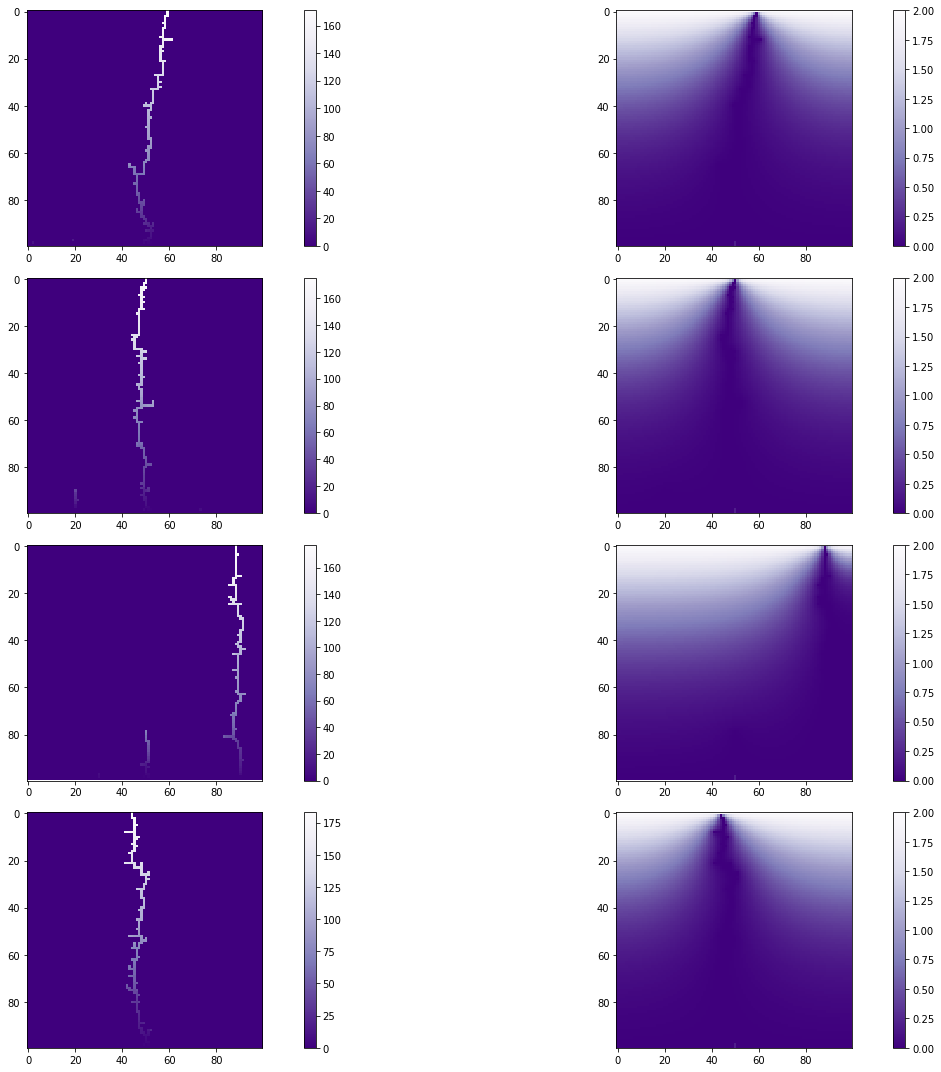

In [5]:
plt.figure(1,figsize=(20,15))
z, b, c, Lx, Ly, rod_pot, rod_height = set_conditions(Lx = 100, Ly = 100)
c1,s1,sprob1 = calc_bolt(z,b,c,Lx,Ly, rod_pot, rod_height)
z, b, c, Lx, Ly, rod_pot, rod_height = set_conditions(Lx = 100, Ly = 100)
c2,s2,sprob2 = calc_bolt(z,b,c,Lx,Ly, rod_pot, rod_height)
z, b, c, Lx, Ly, rod_pot, rod_height = set_conditions(Lx = 100, Ly = 100)
c3,s3,sprob3 = calc_bolt(z,b,c,Lx,Ly, rod_pot, rod_height)
z, b, c, Lx, Ly, rod_pot, rod_height = set_conditions(Lx = 100, Ly = 100)
c4,s4,sprob4 = calc_bolt(z,b,c,Lx,Ly, rod_pot, rod_height)

plt.subplot(4,2,1)
plt.imshow(c1.T, cmap="Purples_r") #create a plot of the lightning's path
plt.colorbar()

plt.subplot(4,2,2)
plt.imshow(s1.T, cmap="Purples_r") #create a plot of the final potential
plt.colorbar()

plt.subplot(4,2,3)
plt.imshow(c2.T, cmap="Purples_r") #create a plot of the lightning's path
plt.colorbar()

plt.subplot(4,2,4)
plt.imshow(s2.T, cmap="Purples_r") #create a plot of the final potential
plt.colorbar()

plt.subplot(4,2,5)
plt.imshow(c3.T, cmap="Purples_r") #create a plot of the lightning's path
plt.colorbar()

plt.subplot(4,2,6)
plt.imshow(s3.T, cmap="Purples_r") #create a plot of the final potential
plt.colorbar()

plt.subplot(4,2,7)
plt.imshow(c4.T, cmap="Purples_r") #create a plot of the lightning's path
plt.colorbar()

plt.subplot(4,2,8)
plt.imshow(s4.T, cmap="Purples_r") #create a plot of the final potential
plt.colorbar()

plt.tight_layout()
plt.show()

After running these simulations and plots dozens of times, we see that the majority of the lightning strikes will strike the lightning rod. Occasionally we get a lightning strike that does not strike the rod, and in these cases we noted that the strike struck quite a distance from the rod. This is due to the rod making a 45 degree "cone of protection" under it, as shown in the figure below.

This means that if we want to protect large structures, we have to set up several rods to protect it well enough. (see figure below with overhead ground wire)

<img src="https://cdn.britannica.com/s:700x450/31/24031-004-8D61DAC0.jpg" alt="45 degree cone of protection image" title="Image from Britannica.com" />

__[Source](https://www.britannica.com/technology/lightning-rod)__



We'll now look at these types of metals with conductivity $\sigma$, specific heat $H_{C}$ and density $\rho$.

Gold: 
<br>
$\sigma = 4.1 \cdot 10^{7}\ S/m$
<br>
$H_{C} = 125.604\ J / (kg K)$
<br>
$\rho = 19300\ \text{kg/m}^{3}$

Copper: 
<br>
$\sigma = 5.96 \cdot 10^{7}\ S/m$
<br>
$H_{C} = 376.812\ J / (kg K) $
<br>
$\rho = 8960\ \text{kg/m}^{3}$

Aliminium: 
<br>
$\sigma = 3.77 \cdot 10^{7}\ S/m$
<br>
$H_{C} = 921.096\ J / (kg K)$
<br>
$\rho = 2600\ \text{kg/m}^{3}$

Silver: 
<br>
$\sigma = 6.3 \cdot 10^{7}\ S/m$
<br>
$ H_{C} = 238.6476\ J / (kg K) $
<br>
$\rho = 10500\ \text{kg/m}^{3}$

Iron: 
<br>
$\sigma = 1 \cdot 10^{7}\ S/m$
<br>
$ H_{C} = 460.548\ J / (kg K)$
<br>
$\rho = 7870\ \text{kg/m}^{3}$

We can calculate the resistance in a conductor with the formula: $R = \frac{L}{A\sigma}$ where $L$ is the length of the conductor, $A$ is the cross sectional area and $\sigma$ is the conductivity of the conductor.



We want to calculate the energy going through a conductor(the lightning rod and wire in this case), to do this we can use the formula $T = \frac{E}{H_{C}\ m}$, where E is the energy being passed through the system, $H_{C}$ is the specific heat of the conductor and $m$ is the mass of the conductor.
<br>

We know that $E = P t$ where $P = I^2R$, $t$ is the time the current is passed, inserting all this gives us:
<br>

$$ T = \frac{I^{2}Rt}{H_{C}m}  $$
<br>


We now have to find some baseline currents for our lightning strikes, through our research we found that lightning strikes can have very varying currents, from as low as 3kA to as high as 200kA. We decided to test the entire range of currents for a couple of different lengths of materials

__[Source](https://hypertextbook.com/facts/1997/BrookeHaramija.shtml)__

Lightning rods are connected to ground by a lot of different means, some are connected to the plumbing of the building, some are connected to structural metal frames and some are simply connected to ground by a wire from the rod. 

Estimating the amount of metal in a house's plumbing or structural frames is not that interesting in this case, since the amount of metal will easily be able to dissipate the energy from a lightning strike. We decided to look at some standard gauge wire, with PVC insulation, of different lengths. 

We deem a setup safe if the temperature rise in the wire is below the melting point of the PVC insulation, which is 
105 degrees celcius, if the conductor material heats up more than this we would deem it unsafe for use in this application.

__[Source](https://www.awcwire.com/insulation-materials)__

In [6]:
# Here we define a dictionary with the values of the different properties

names = ["Gold", "Copper", "Aluminium", "Silver", "Iron"] # Conductor names
sigma = [(4.1* 10**7), (5.96* 10**7), (3.77* 10**7), (6.3* 10**7), (1* 10**7)] # S/m
spec_heat = [125.604, 376.812, 921.096, 238.6476, 460.548] # J / (kg K)
rho = [19300, 8960, 2600, 10500, 7870] # kg/m^3

materials = {}               # setup an empty dictionary to populate
for i in range(len(names)):  # populate the dictionary with the given values
    values = {}
    values["sigma"] = sigma[i]
    values["spec_heat"] = spec_heat[i]
    values["rho"] = rho[i]
    materials[names[i]] = values

In [7]:
# Define a couple of functions for calculating Ohm's law and the temperature increase
# in a wire for a given wire

def resistance(L, A, sigma):
    """
    Calculates the resistance of a given length of wire
    """
    return (L / (A*sigma))

def temp(R, I, t, Hc, Vol, rho):
    """
    Calculate the increase in temperature based 
    on the energy passed in the conductor
    """
    return ((R * (I**2) * t) / (Hc * Vol * rho))

We found differing regulations about roof heights in Norway, from our research we decided that 4.5 meters and 8.0 meters were sensible values for single storey and two storey buildings respectively. 

In our calculations we choose to assume that the cable connecting the rod to ground goes straight down to ground from the roof, to account for the length of wire that needs to be in the ground for a proper grounding to take place we assumed 0.5 metres would be sufficient.

In [8]:
# Setup the one storey and two storey house parameters.

one_storey_rod = 1.0    #m
two_storey_rod = 1.5    #m
rod_gauge = (0.01**2) * np.pi # m^2

one_storey_wire = 5.0   #m
two_storey_wire = 8.5   #m

wire_gauge = np.array([120, 95, 70, 55, 50, 35, 25, 16, 10, 6]) * (10**-6) #m^2   
# These values are AWG 4/0, 3/0, 2/0, 1/0, 1, 2, 4, 6, 8 and 10 in m^2

for conductor in materials:
    R_rod_os = resistance(one_storey_rod, rod_gauge, materials[conductor]["sigma"])# Calc resistance of one storey rod
    R_rod_ts = resistance(two_storey_rod, rod_gauge, materials[conductor]["sigma"])# Calc resistance of two storey rod
    
    R_os = resistance(one_storey_wire, wire_gauge, materials[conductor]["sigma"])# Calc resistance of one storey wire
    R_ts = resistance(two_storey_wire, wire_gauge, materials[conductor]["sigma"])# Calc resistance of one storey wire
    
    resistances = {}
    resistances["os"] = (R_rod_os + R_os) # sums the rod and wire resistances
    resistances["ts"] = (R_rod_ts + R_ts) # sums the rod and wire resistances
    
    materials[conductor]["resistances"] = resistances # adds the resistances into our main dictionary

In [9]:
# Here we make a couple of nice looking tables using pandas

gauges = ["4/0","3/0","2/0","1/0","1","2","4","6","8","10"]  # wire gauges
mat_list = [r"$Gold\ R(\Omega)$",r"$Copper\ R(\Omega)$",r"$Aluminium\ R(\Omega)$",
            r"$Silver\ R(\Omega)$", r"$Iron\ R(\Omega)$"]    # names with latex syntax for the plots and tables

resistances_os = [] 
resistances_ts = []

for conductor in materials:
    resistances_os.append(materials[conductor]["resistances"]["os"])
    resistances_ts.append(materials[conductor]["resistances"]["ts"])
    

res_table_os = pd.DataFrame(resistances_os, 
                            columns=gauges, 
                            index=mat_list)

res_table_ts = pd.DataFrame(resistances_ts, 
                            columns=gauges, 
                            index=mat_list)

In [10]:
def highlight_min(s):
    '''
    highlight the minimum in a Series.
    '''
    is_min = s == s.min()
    return ['background-color: lightblue' if v else '' for v in is_min]

def highlight_max(s):
    '''
    highlight the max in a Series.
    '''
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

def color_val(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for values over 1
    strings, black otherwise.
    """
    if val > 1:
        color = 'pink'
    elif 1 >= val > 0.75:
        color = 'darkorange'
    elif 0.75 >= val > 0.5:
        color = 'orange'
    elif 0.25 >= val > 0:
        color = 'green'
    else:
        color = 'black'
    return 'color: %s' % color

Here we can see a couple of tables which lists the resistances of our different situations, the first is the resistances of the different wire gauges, and materials, for one storey buildings, the second is for two storey buildings.

In [11]:
res_table_os.style.apply(highlight_min).apply(highlight_max)

,4/0,3/0,2/0,1/0,1,2,4,6,8,10
$Gold\ R(\Omega)$,0.0010939,0.00136133,0.0018198,0.00229493,0.00251666,0.00356196,0.00495569,0.00769959,0.0122728,0.0204028
$Copper\ R(\Omega)$,0.000752513,0.000936488,0.00125187,0.00157873,0.00173126,0.00245034,0.00340911,0.0052967,0.00844267,0.0140355
$Aluminium\ R(\Omega)$,0.00118965,0.0014805,0.00197909,0.00249581,0.00273695,0.00387375,0.00538947,0.00837356,0.013347,0.0221888
$Silver\ R(\Omega)$,0.000711901,0.000885947,0.00118431,0.00149353,0.00163783,0.0023181,0.00322513,0.00501084,0.00798703,0.013278
$Iron\ R(\Omega)$,0.00448498,0.00558147,0.00746117,0.00940922,0.0103183,0.014604,0.0203183,0.0315683,0.0503183,0.0836516


In [12]:
res_table_ts.style.apply(highlight_min).apply(highlight_max)

,4/0,3/0,2/0,1/0,1,2,4,6,8,10
$Gold\ R(\Omega)$,0.0018441,0.00229874,0.00307813,0.00388586,0.0042628,0.0060398,0.00840914,0.0130738,0.0208482,0.0346693
$Copper\ R(\Omega)$,0.00126859,0.00158135,0.0021175,0.00267316,0.00293246,0.0041549,0.00578481,0.0089937,0.0143419,0.0238497
$Aluminium\ R(\Omega)$,0.00200552,0.00249996,0.00334757,0.004226,0.00463593,0.00656848,0.00914522,0.0142182,0.0226731,0.037704
$Silver\ R(\Omega)$,0.00120013,0.00149601,0.00200323,0.00252889,0.0027742,0.00393066,0.00547261,0.00850833,0.0135679,0.0225626
$Iron\ R(\Omega)$,0.0075608,0.00942483,0.0126203,0.015932,0.0174775,0.0247632,0.0344775,0.0536025,0.0854775,0.142144


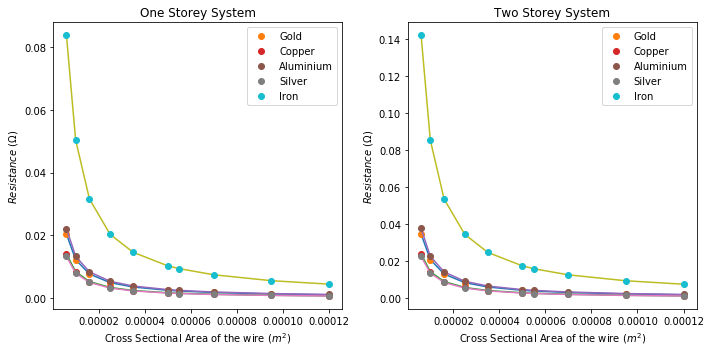

In [13]:
# Here we make a quick graphical representation of the values shown above

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("One Storey System")
for conductor in materials:
    plt.plot(wire_gauge, materials[conductor]["resistances"]["os"], "-")
    plt.plot(wire_gauge, materials[conductor]["resistances"]["os"], "o", label="%s"%(conductor))
plt.legend()
plt.xlabel(r"Cross Sectional Area of the wire $(m^{2})$")
plt.ylabel(r"$Resistance\ (\Omega)$")
    
plt.subplot(1,2,2)
plt.title("Two Storey System")
for conductor in materials:
    plt.plot(wire_gauge, materials[conductor]["resistances"]["ts"], "-")
    plt.plot(wire_gauge, materials[conductor]["resistances"]["ts"], "o", label="%s"%(conductor))
plt.legend()
plt.xlabel(r"Cross Sectional Area of the wire $(m^{2})$")
plt.ylabel(r"$Resistance\ (\Omega)$")

plt.tight_layout()
plt.show()

As we can see from these tables and plots Silver has the least resistance, followed by Copper, then Gold, then Aliminium and finally Iron. We can also take note that the resistance of the wires increases as the wire gauge becomes smaller. (4/0 is the largest wire, while 4 is the smallest)

In [14]:
# Calculates the volume of our conductors

for conductor in materials:
    vol = {}
    vol_os = (rod_gauge * one_storey_rod) + (wire_gauge * one_storey_wire)
    vol_ts = (rod_gauge * two_storey_rod) + (wire_gauge * two_storey_wire)
    
    vol["os"] = vol_os
    vol["ts"] = vol_ts
    
    materials[conductor]["vol"] = vol

In [15]:
volumes_os = [materials["Gold"]["vol"]["os"]]
volumes_ts = [materials["Gold"]["vol"]["ts"]]

vol_os = pd.DataFrame(volumes_os,
                      columns=gauges, 
                      index=[r"Volume $m^{3}$"])

vol_ts = pd.DataFrame(volumes_ts,
                      columns=gauges, 
                      index=[r"Volume $m^{3}$"])

In [16]:
vol_os

,4/0,3/0,2/0,1/0,1,2,4,6,8,10
Volume $m^{3}$,0.000914,0.000789,0.000664,0.000589,0.000564,0.000489,0.000439,0.000394,0.000364,0.000344


In [17]:
vol_ts

,4/0,3/0,2/0,1/0,1,2,4,6,8,10
Volume $m^{3}$,0.001491,0.001279,0.001066,0.000939,0.000896,0.000769,0.000684,0.000607,0.000556,0.000522


Here we can see the volumes of the different setups.

In [18]:
# Calculate the temperature rise 

currents = np.linspace(3,200,101) * (10**3) # setting up the currents with a linspace from 3-200 kA
time_strike = 65 * (10**-6) # microseconds

for conductor in materials:
    os = {} ; ts = {}
    for i in range(len(materials[conductor]["resistances"]["os"])):
        
        # Calculates the temperature rise in the one storey setup
        temp_os = temp(R = materials[conductor]["resistances"]["os"][i],
                       I = currents,
                       t = time_strike,
                       Hc = materials[conductor]["spec_heat"],
                       Vol = materials[conductor]["vol"]["os"][i],
                       rho = materials[conductor]["rho"])
        
        # Calculates the temperature rise in the Two storey setup
        temp_ts = temp(R = materials[conductor]["resistances"]["ts"][i],
                       I = currents,
                       t = time_strike,
                       Hc = materials[conductor]["spec_heat"],
                       Vol = materials[conductor]["vol"]["ts"][i],
                       rho = materials[conductor]["rho"])
        
        
        os["%s"%(i)] = temp_os
        ts["%s"%(i)] = temp_ts
    
    materials[conductor]["temps_os"] = os
    materials[conductor]["temps_ts"] = ts

In [19]:
def plot(material,current):
    
    plt.figure(figsize=(16,9))
    
    print("%s: "%(material))
    
    plt.subplot(1,2,1)
    plt.title("One Storey System")
    for i in range(len(materials[material]["temps_os"])):
        plt.plot(current,materials[material]["temps_os"]["%s"%(i)], label="AWG: %s"%(gauges[i]))
    plt.legend()
    plt.xlabel(r"$Current\ (A)$")
    plt.ylabel(r"$Temperature\ Rise\ (K)$")
    
    plt.subplot(1,2,2)
    plt.title("Two Storey System")
    for i in range(len(materials[material]["temps_ts"])):
        plt.plot(current,materials[material]["temps_ts"]["%s"%(i)], label="AWG: %s"%(gauges[i]))
    plt.legend()  
    plt.xlabel(r"$Current\ (A)$")
    plt.ylabel(r"$Temperature\ Rise\ (K)$")
    
    plt.show()
        

Gold: 


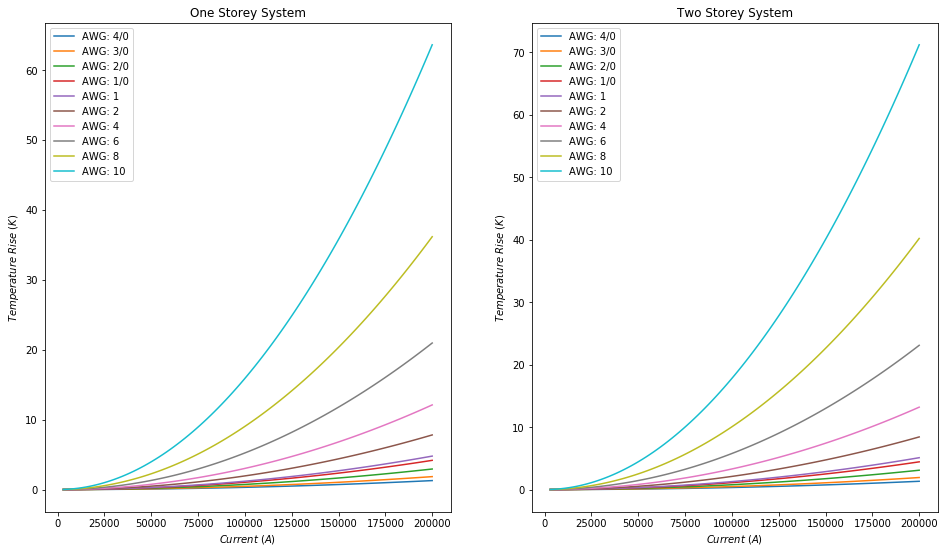

In [20]:
plot("Gold", currents)

Copper: 


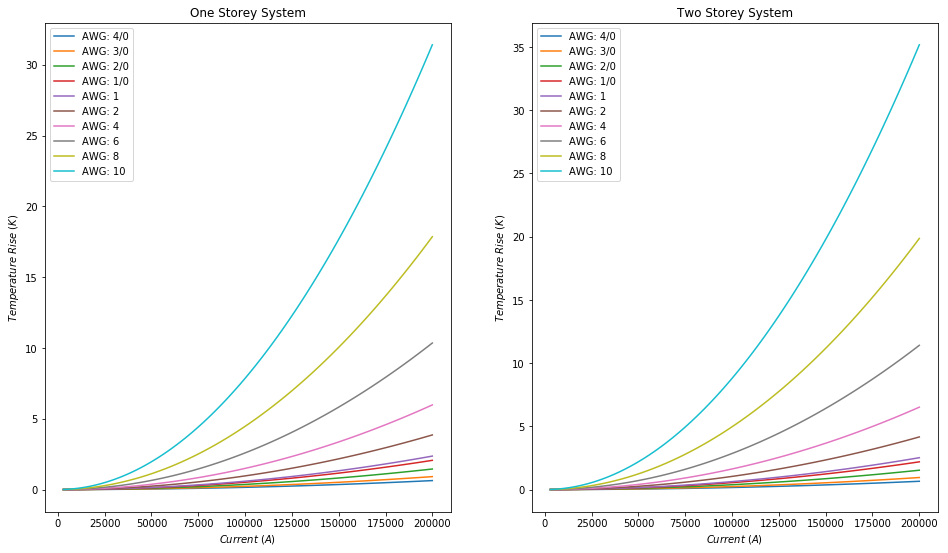

In [21]:
plot("Copper", currents)

Aluminium: 


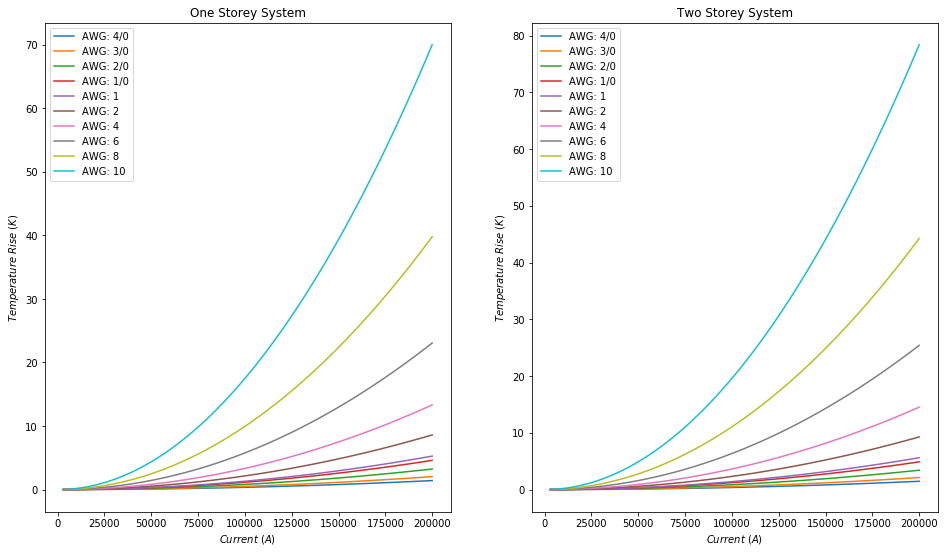

In [22]:
plot("Aluminium", currents)

Silver: 


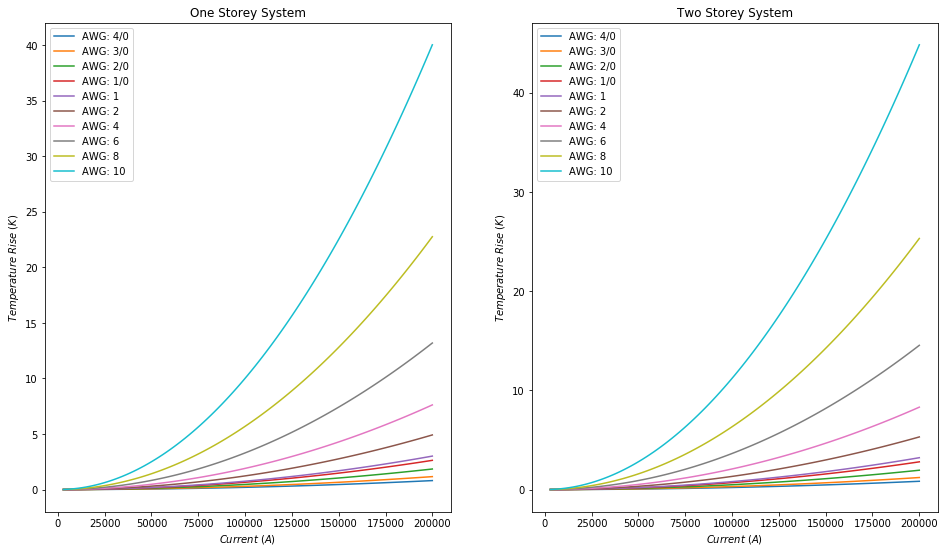

In [23]:
plot("Silver", currents)

Iron: 


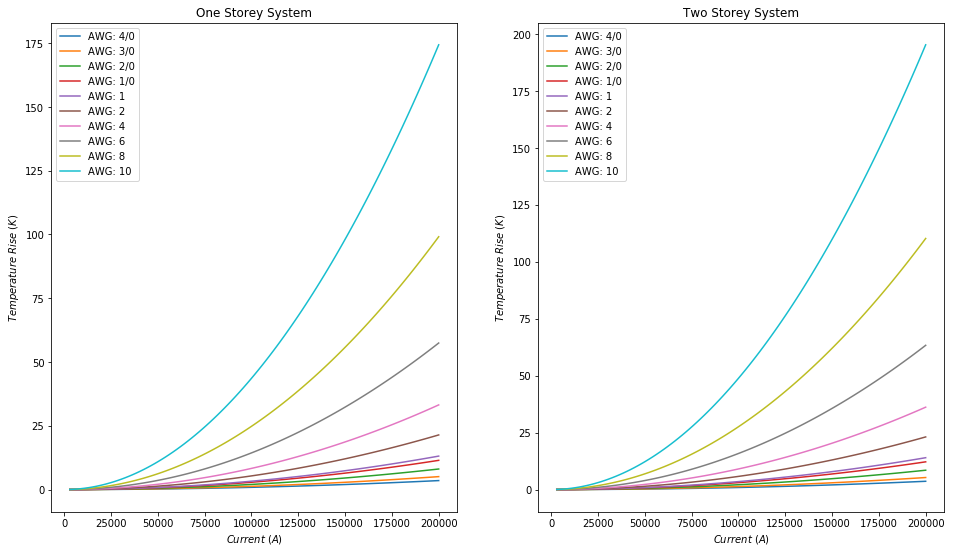

In [24]:
plot("Iron", currents)

From these plots we can see that in all cases, the temperature goes up more the thinner the wire. This is quite intuitive, since there's less material to pass the energy through.

We can also note that copper seems to be the best conductor, it's temperatures are the lowest across all wire gauges, while iron is the worst due to it's temperatures being the highest across all wire gauges.

Now we will compare the maximum temperature increases to the melting point of the PVC insulation used on the wires.

In [25]:
# Gets the maximum temperature increase for each material and gauge

melt_point_pvc = 105 # degrees C

for conductor in materials:
    max_temps_os = {}
    max_temps_ts = {}
    
    for i in range(len(materials[conductor]["temps_os"])):
        # We add 20 degrees C to each max temp rise, since we assume we're working in an environment with
        # a temperature of 20 degrees
        max_temps_os["%s"%(i)] = np.amax(materials[conductor]["temps_os"]["%s"%(i)]) + 20 # add 20 degrees C
        max_temps_ts["%s"%(i)] = np.amax(materials[conductor]["temps_ts"]["%s"%(i)]) + 20
    
    materials[conductor]["max_temp_os"] = max_temps_os
    materials[conductor]["max_temp_ts"] = max_temps_ts

In [26]:
melt_compare_os = []
melt_compare_ts = []

for conductor in materials:
    temp_list_os = []
    temp_list_ts = []
    
    for i in range(len(materials[conductor]["max_temp_os"])):
        temp_list_os.append((materials[conductor]["max_temp_os"]["%s"%(i)] / melt_point_pvc))
        temp_list_ts.append((materials[conductor]["max_temp_ts"]["%s"%(i)] / melt_point_pvc))

    melt_compare_os.append(temp_list_os)
    melt_compare_ts.append(temp_list_ts)

melt_os = pd.DataFrame(melt_compare_os,
                       columns = gauges,
                       index = mat_list)

melt_ts = pd.DataFrame(melt_compare_ts,
                       columns = gauges,
                       index = mat_list)

In [27]:
melt_os.style.format("{:.2%}").apply(highlight_min).apply(highlight_max).applymap(color_val)

,4/0,3/0,2/0,1/0,1,2,4,6,8,10
$Gold\ R(\Omega)$,20.27%,20.81%,21.85%,23.03%,23.60%,26.49%,30.57%,39.00%,53.47%,79.60%
$Copper\ R(\Omega)$,19.65%,19.92%,20.43%,21.01%,21.30%,22.72%,24.74%,28.90%,36.05%,48.96%
$Aluminium\ R(\Omega)$,20.39%,20.99%,22.13%,23.43%,24.06%,27.24%,31.74%,41.01%,56.94%,85.71%
$Silver\ R(\Omega)$,19.82%,20.16%,20.81%,21.55%,21.92%,23.73%,26.30%,31.61%,40.72%,57.17%
$Iron\ R(\Omega)$,22.40%,23.88%,26.72%,29.96%,31.54%,39.44%,50.66%,73.76%,113.45%,185.10%


In [28]:
melt_ts.style.format("{:.2%}").apply(highlight_min).apply(highlight_max).applymap(color_val)

,4/0,3/0,2/0,1/0,1,2,4,6,8,10
$Gold\ R(\Omega)$,20.31%,20.88%,22.00%,23.28%,23.91%,27.07%,31.61%,41.04%,57.33%,86.86%
$Copper\ R(\Omega)$,19.67%,19.95%,20.50%,21.14%,21.45%,23.01%,25.25%,29.91%,37.96%,52.54%
$Aluminium\ R(\Omega)$,20.44%,21.07%,22.29%,23.70%,24.40%,27.88%,32.88%,43.26%,61.19%,93.70%
$Silver\ R(\Omega)$,19.84%,20.20%,20.90%,21.71%,22.11%,24.10%,26.96%,32.89%,43.15%,61.74%
$Iron\ R(\Omega)$,22.51%,24.08%,27.13%,30.64%,32.37%,41.05%,53.50%,79.35%,124.03%,205.00%


These tables show how close to the melting point of the PVC insulation that the cables got as a percentage of the melting point of the PVC insulation.

# Conclusion

## Lightning Rod Simulation

From our simulations we see that having a lightning rod present will in the majority of the cases cause the lightning to strike the rod. As we noted earlier the rod will make a 45 degree "cone of protection" under it, this means that one should take this into account when setting up lightning rods for practical applications.

## Lightning Rod Materials

We chose to test a few metals for these calculations, Gold, Copper, Aluminium, Silver and Iron were our materials of choice.

From our calculations of resistance silver seemed to be the best candidate, due to it having the lowest resistance across all wire gauges. The difference in resistance between silver and the second best material(copper) was small, thus both are good conductors.

However when it came to the final result with the temperature increase, copper was clearly the best candidate, due to it having the lowest temperature increase across all wire gauges. The difference in temperature increase was not that large when it came to the bigger wire gauges, but as the wires became smaller the differences became significantly greater.

Most of the materials were well within safe temperature increase across the entire range of current, iron however was not for the thinnest gauges, aluminium and gold got dangerously close for the thinnest gauge.

For all applications copper seems to be the best alternative.

## Words of wisdom:

Check your units, always, always, always, check your units!